<a href="https://colab.research.google.com/github/michael-0907/tibami/blob/main/bank_after_discussion_0324_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from xgboost import XGBClassifier
import os

import joblib

In [2]:
data = pd.read_csv("/content/sample_data/bank-full.csv", encoding="utf-8", sep=";")
display(data.shape)
display(data.head(3))

(45211, 17)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [3]:
df = data.copy()

# 刪除有疑慮的欄位
df = data.drop(columns=["month", "day"])

# 刪除有unknown的行
df = df[~df.isin(["unknown"]).any(axis=1)]

df.shape


(7842, 15)

In [4]:
# 將balance < 0 的刪除
# balance < 0  的刪除後， padys=-1 的就沒了，pdays的最小值變成 1
df = df[df["balance"] >= 0 ]
df.shape


(7371, 15)

In [5]:
for col in df.columns:
  unknown_col = df[col].isin(["unknown"])
  if unknown_col.any():
    print(f"含有unknown的特徵: {col}, 數量: {unknown_col.sum()}")
unknown_row = df.isin(["unknown"]).any(axis=1)
print(f"總行數: {df.shape[0]}")
print(f"含有unknown的行數: {unknown_row.sum()}")


總行數: 7371
含有unknown的行數: 0


In [ ]:
column_info = []
for col in df.columns:
  info_dtype = df[col].dtype
  info_isna = df[col].isna().any()
  info_nunique = df[col].nunique()
  info_min = df[col].min()
  info_max = df[col].max()
  info_unique_20 = df[col].unique()[0: 20]

  c = [col, info_dtype, info_isna, info_nunique, info_min, info_max, info_unique_20]
  column_info.append(c)
columns = ["col_name", "dtype", "isna", "unique_num", "min", "max", "unique_20"]
column_info_df = pd.DataFrame(column_info, columns=columns)
display(column_info_df)

# column_info_df.to_csv("column_info_bank.csv")


In [7]:
# 目標變數編碼

df[col] = df[col].map({"yes": 1, "no": 0})
# display(df["y"].value_counts())


In [8]:
# 二元特徵及目標變數編碼
ordinal_features = ["default", "housing", "loan"]

for col in ordinal_features:
  df[col] = df[col].map({"yes": 1, "no": 0})



In [12]:
# 提取特徵變數及目標變數

X = df.drop(columns=["y"])
y = df["y"]
print(X.shape, y.shape)


(7371, 14) (7371,)


In [49]:
# 切分訓練組、驗證組、測試組

# 切出測試集(保留最後評估用)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# 剩下的資料切成訓練、驗證集
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, shuffle=True, stratify=y_temp)
display(X_temp.shape, y_temp.shape)
display(X_test.shape, y_test.shape)
display(X_train.shape, y_train.shape)
display(X_val.shape, y_val.shape)
print(X_train.index.equals(y_train.index))
print(X_test.index.equals(y_test.index))
print(X_val.index.equals(y_val.index))


(5896, 14)

(5896,)

(1475, 14)

(1475,)

(4422, 14)

(4422,)

(1474, 14)

(1474,)

True
True
True


In [34]:
display(X_train.dtypes.value_counts())

,count
int64,9
object,5


In [50]:
# 欄位分類

int_columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'] # 數值型欄位，做標準化縮放
ordinal_columns = ["education", "contact"] # 類別型欄位，做標籤編碼
binary_columns = ["default", "housing", "loan"] # 二元欄位，前面已轉換，預處理不再做
ohe_columns = ['job', 'marital', 'poutcome'] # 類別型欄位，做ohe


all_columns = int_columns +  ordinal_columns + binary_columns + ohe_columns
print(len(all_columns))
# all_columns


14


In [51]:
# 設置前處理器

categories_order = [
    ["primary", "secondary", "tertiary"],
    ['cellular', 'telephone']
]

preprocessor = ColumnTransformer(transformers=[
    ("int", StandardScaler(), int_columns),
    ("ordinal", OrdinalEncoder(categories=categories_order), ordinal_columns),
    ("passthrough", "passthrough", binary_columns),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ohe_columns)
])


In [52]:
# 執行預處理

X_train_preproceed = preprocessor.fit_transform(X_train) # 訓練組預處理
X_val_preproceed = preprocessor.transform(X_val) # 測試組預處


In [53]:
# 整理欄位

ohe_columns = list(preprocessor.named_transformers_["ohe"].get_feature_names_out()) # 取得預處理器中的ohe欄位名稱
all_preprocessed_columns = int_columns +  ordinal_columns + binary_columns + ohe_columns # 整合所有欄位名稱
len(all_preprocessed_columns)

X_train_preproceed = pd.DataFrame(X_train_preproceed, columns=all_preprocessed_columns, index=X_train.index) # 訓練組重新生成dataframe
X_val_preproceed = pd.DataFrame(X_val_preproceed, columns=all_preprocessed_columns, index=X_val.index) # 測試組重新生成dataframe

display(X_train_preproceed.shape, y_train.shape)
display(X_val_preproceed.shape, y_val.shape)

display(X_train_preproceed.head(3))
display(X_val_preproceed.head(3))


(4422, 28)

(4422,)

(1474, 28)

(1474,)

,age,balance,duration,campaign,pdays,previous,education,contact,default,housing,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success
35777,-0.245234,-0.435792,-0.737583,-0.678116,1.319633,-0.223202,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
40885,0.541785,0.210741,-0.102427,-0.678116,-1.024494,-0.409674,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
37975,-1.207146,-0.441751,5.088918,-0.042948,1.194375,-0.409674,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


,age,balance,duration,campaign,pdays,previous,education,contact,default,housing,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success
41264,-0.332680,-0.468864,-0.288739,-0.678116,-0.228206,-0.409674,2.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
43930,0.891571,-0.506702,-0.352255,1.227388,-1.069229,-0.223202,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
34928,-0.595020,-0.260305,-0.026208,-0.678116,0.433875,0.149743,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [54]:
# 定義模型

model_def = {
    "random_forest": {
        "model": RandomForestClassifier(n_estimators=120, max_depth=15, min_samples_leaf=3, class_weight="balanced", random_state=42),
        "cache_path": "/content/rf_model.pkl"
    },
    "xgb": {
        "model": XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, n_estimators=100,
                    max_depth=3, learning_rate=0.2, colsample_bytree=0.8, gamma=0.1, min_child_weight=1, scale_pos_weight=2.5,
                    subsample=1, reg_alpha=0.1, reg_lambda=100),
        "cache_path": "/content/xgb_model.pkl"
    },
    "logical_reg": {
        "model": LogisticRegression(penalty='l2', C=0.1, class_weight='balanced', solver='liblinear', max_iter=1000, random_state=42),
        "cache_path": "/content/lg_model.pkl"
    }
}



In [55]:
# 訓練模型

for name, data in model_def.items():
  path = data["cache_path"]
  if os.path.exists(path):
    print(f"model {name} 已存在")
  else:
    model = data["model"].fit(X_train_preproceed, y_train)
    joblib.dump(model, path)
    print(f"mode {name} trained and saved")





model random_forest 已存在
model xgb 已存在
model logical_reg 已存在


In [95]:
# 對驗證組進行預測，並取得 y_score

train_model_result = {}
val_model_result = {}

for name, data in model_def.items():
  path = data["cache_path"]
  model = joblib.load(path)
  train_score = model.predict_proba(X_train_preproceed)[:, 1]
  train_pred = (train_score >= 0.5).astype(float)

  val_score = model.predict_proba(X_val_preproceed)[:, 1]
  val_pred = (val_score >= 0.5).astype(float)

  train_accuracy = accuracy_score(y_train, train_pred)
  val_accuracy = accuracy_score(y_val, val_pred)

  train_model_result[f"train_{name}"] = {"accuracy": f"{train_accuracy:.3f}", "score": train_score}
  val_model_result[f"val_{name}"] = {"accuracy": f"{train_accuracy:.3f}", "score": val_score}


train_model_result
val_model_result




{'val_random_forest': {'accuracy': '0.925',
  'score': array([0.61923193, 0.68704864, 0.13897333, ..., 0.15270747, 0.17204917,
         0.05983841])},
 'val_xgb': {'accuracy': '0.843',
  'score': array([0.551936  , 0.599698  , 0.13687988, ..., 0.12290528, 0.15912612,
         0.06075998], dtype=float32)},
 'val_logical_reg': {'accuracy': '0.816',
  'score': array([0.67192873, 0.518312  , 0.24267159, ..., 0.23495996, 0.20073938,
         0.15098404])}}

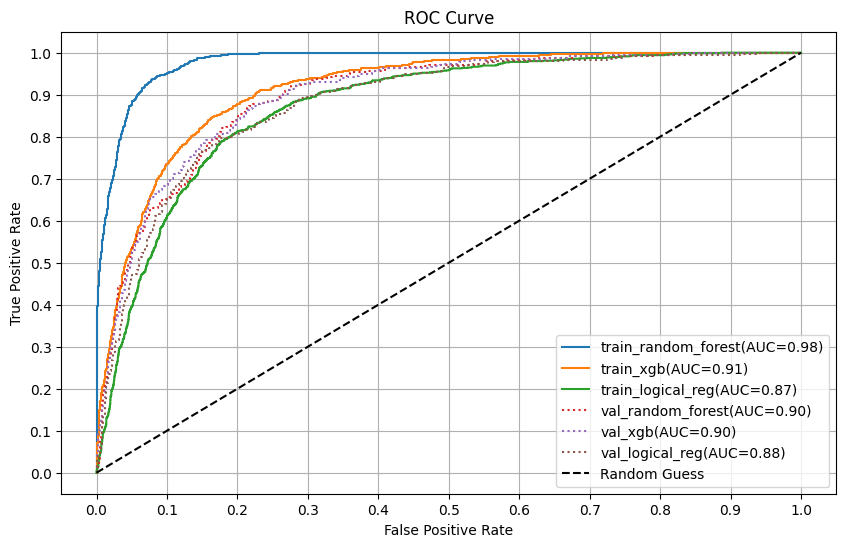

In [96]:
# 畫ROC-AUC

plt.figure(figsize=(10, 6))
for name, result in train_model_result.items():
  fpr, tpr, _ = roc_curve(y_train, result["score"])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label=f"{name}(AUC={roc_auc:.2f})")

for name, result in val_model_result.items():
  fpr, tpr, _ = roc_curve(y_val, result["score"])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, ":", label=f"{name}(AUC={roc_auc:.2f})")


plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.yticks(ticks=np.arange(0, 1.1, 0.1))
plt.title("ROC Curve")
plt.legend()
plt.grid(True)


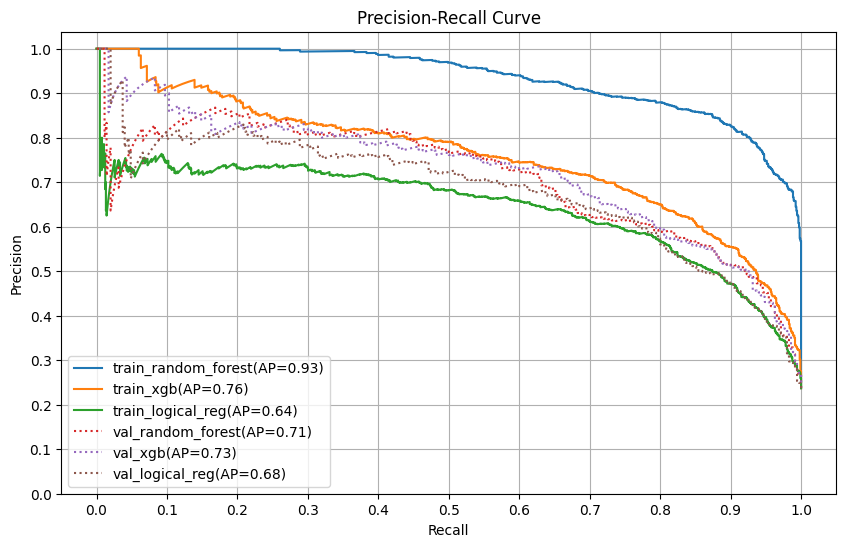

In [98]:
# 畫PR-AUC

plt.figure(figsize=(10, 6))
for name, result in train_model_result.items():
    precision, recall, _ = precision_recall_curve(y_train, result["score"])
    ap_score = average_precision_score(y_train, result["score"])
    plt.plot(recall, precision, label=f"{name}(AP={ap_score:.2f})")

for name, result in val_model_result.items():
    precision, recall, _ = precision_recall_curve(y_val, result["score"])
    ap_score = average_precision_score(y_val, result["score"])
    plt.plot(recall, precision, ":" ,label=f"{name}(AP={ap_score:.2f})")


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.yticks(ticks=np.arange(0, 1.1, 0.1))
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)

# rfc 過擬合，xgb 最穩定, logical reg 訓練比驗證差

